In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import os
import PIL.Image as Image
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from plot_utils.MNIST_plot_utils import scale_to_unit_interval, save_ten_images, plot_ten_images, tile_raster_images
from plot_utils.ts_plot_utils import plot_ts, plot_ts_recon, save_ts, save_ts_recon
from plot_utils.heatmap import heatmap, annotate_heatmap

seed=30
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
#gpu_devices = tf.config.experimental.list_physical_devices("GPU")
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)

In [3]:
def corrupt(X, eps, p_corr):
    X_all_corr = np.random.random(size=X.shape)
    #X_all_corr = X + eps * np.random.randn(X.shape[0], X.shape[1])
    #X_all_corr = np.clip(X_all_corr, 0, 1)
    mask = np.random.choice([0, 1], size=X.shape, p=[1-p_corr, p_corr]) != 0
    X_corr = X.copy()
    X_corr[mask] = X_all_corr[mask]
    return X_corr

def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

In [4]:
def prox_l1(lam, x):
    return (x > lam) * (x - lam) + (x < -lam) * (x + lam)

def prox_l21(lam, x):
    e = np.linalg.norm(x, axis=0, keepdims=False)
    for i in range(len(e)):
        if e[i] > lam:
            x[:,i] = x[:,i] - lam*e[i]
        else:
            x[:,i] = np.zeros(len(x[:,i]))
    return x
    

def get_Dense_encoder(input_size, dense_units):
    encoder = tf.keras.Sequential()
    #encoder = tf.keras.Sequential([
    #    layers.Input(shape=(input_size)),
    #    layers.Dense(units=dense_units[0], activation='relu'),
    #    layers.Dense(units=dense_units[1], activation='relu'),    
    #], name='Encoder')
    encoder.add(layers.Input(shape=(input_size)))
    for i in range(len(dense_units)):
        encoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    return encoder

def get_Dense_decoder(input_size, dense_units):
    decoder = tf.keras.Sequential()
    #decoder = tf.keras.Sequential([
    #    layers.Input(shape=(dense_units[1])),
    #    layers.Dense(units=dense_units[0], activation='relu'),
    #    layers.Dense(units=input_size, activation='sigmoid'),
    #], name='Decoder')
    decoder.add(layers.Input(shape=(dense_units[-1])))
    for i in reversed(range(len(dense_units)-1)):
        decoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    decoder.add(layers.Dense(units=input_size, activation='sigmoid'))
    return decoder

def get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout):
    encoder = tf.keras.Sequential()
    if len(LSTM_units) > 0:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)))
        for i in range(len(LSTM_units)-2):
            encoder.add(layers.LSTM(units=LSTM_units[i+1], dropout=LSTM_dropout, return_sequences=True))
        encoder.add(layers.LSTM(units=LSTM_units[-1], dropout=LSTM_dropout, return_sequences=False))
    else:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=False, input_shape=(timesteps, features)))            
    #encoder = tf.keras.Sequential([
    #    layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)),
    #    layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=False),
    #], name='Encoder')
    return encoder

def get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout):
    decoder = tf.keras.Sequential()
    decoder.add(layers.RepeatVector(timesteps))
    for i in reversed(range(len(LSTM_units))):
        decoder.add(layers.LSTM(units=LSTM_units[i], dropout=LSTM_dropout, return_sequences=True))
    decoder.add(layers.TimeDistributed(layer=layers.Dense(units=features, activation='sigmoid')))
    
    #decoder = tf.keras.Sequential([
    #    layers.RepeatVector(timesteps),
    #    layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=True),
    #    layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True),
    #    layers.TimeDistributed(layer=layers.Dense(units=features)),
    #], name='Decoder')
    return decoder

In [5]:
### Deep Dense Autoencoder Model
class DAE_Dense(Model):
    def __init__(self, input_size, dense_units):
        super(DAE_Dense, self).__init__()
        self.encoder = get_Dense_encoder(input_size, dense_units)
        self.decoder = get_Dense_decoder(input_size, dense_units)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Deep LSTM Autoencoder Model
class DAE_LSTM(Model):
    def __init__(self, timesteps, features, LSTM_units, LSTM_dropout):
        super(DAE_LSTM, self).__init__()
        self.encoder = get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout)
        self.decoder = get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [6]:
### Robust Autoencoder Model
class RobustAutoencoder:
    def __init__(self, AE_type: str, prox_type: str, input_size=784, dense_units=[200, 10], lr=3e-4, timesteps=24, features=1, LSTM_units=[64, 32], LSTM_dropout=0.0):
        super(RobustAutoencoder, self).__init__()
        assert AE_type=='Dense' or AE_type=='LSTM', 'AE_type has to be either Dense or LSTM'
        self.AE_type = AE_type
        
        assert prox_type=='l1' or prox_type=='l21', 'prox_type has to be either l1 or l21'
        self.prox_type = prox_type
        
        if self.AE_type=='Dense':
            self.AE = DAE_Dense(input_size, dense_units)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(input_size))
            #self.AE.summary()
            
        elif self.AE_type=='LSTM':
            self.AE = DAE_LSTM(timesteps, features, LSTM_units, LSTM_dropout)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(timesteps, features))
            #self.AE.summary()
        
        if self.prox_type=='l1':
            self.prox_fn = prox_l1
        elif self.prox_type=='l21':
            self.prox_fn = prox_l21
            
    def train_and_fit(self, X, train_iter: int, AE_train_iter: int, batch_size: int, eps: float, lam: float, verbose=0):
        if self.AE_type == 'Dense':
            self.default_shape = (X.shape[0], X.shape[1])
            self.utils_shape = (X.shape[0], X.shape[1])
        elif self.AE_type == 'LSTM':
            self.default_shape = (X.shape[0], X.shape[1], 1)
            self.utils_shape = (X.shape[0], X.shape[1])
        
        X = X.reshape(self.default_shape)
        self.L = np.zeros(self.default_shape)
        self.S = np.zeros(self.default_shape)
        self.LD = np.zeros(self.default_shape)
        self.LS = X
        
        for i in range(train_iter):
            if verbose!= 0:
                print(f'RAE training iteration: {i+1}')
            self.LD = X - self.S
            # Now fit the autoencoder for some iters
            self.AE.fit(x=self.LD, batch_size=batch_size, epochs=AE_train_iter, verbose=verbose)
            self.LD = self.AE(self.LD).numpy()
            self.S = X - self.LD
            
            self.S = self.S.reshape(self.utils_shape)
            self.S = self.prox_fn(lam=lam, x=self.S.T).T
            self.S = self.S.reshape(self.default_shape)
            
            c1 = tf.linalg.norm(X - self.LD - self.S) / tf.linalg.norm(X)
            c2 = tf.linalg.norm(self.LS - self.LD - self.S) / tf.linalg.norm(X)
            if c1 < eps or c2 < eps:
                print(f'Early Convergence at iter {i+1}')
                break
            self.LS = self.LD + self.S
        return self.LD, self.S
    
    def get_reconstruction(self, X):
        return self.AE(X)
    
    def transform(self, X):
        L = X - self.S
        return self.AE.encode(L)

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))
    
x_train_corr = corrupt(x_train, eps=1., p_corr=0.25)

print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

digit = 4
x_train_digit = x_train[y_train==digit]
np.random.shuffle(x_train_digit)
x_train_others = x_train[y_train!=digit]
np.random.shuffle(x_train_others)

anomaly_perc = 0.05

anomalies = np.random.choice(x_train_digit.shape[0], size=int(x_train_digit.shape[0]*anomaly_perc))
x_train_anomaly = x_train_digit.copy()
x_train_anomaly[anomalies] = x_train_others[:anomalies.shape[0]]
print(f'Total number of {digit}s in the anomaly data: {x_train_anomaly.shape[0]}, correct data: '
      f'{x_train_anomaly.shape[0]-anomalies.shape[0]}, anomalies: {anomalies.shape[0]}')



Train data shape: (60000, 784)
Test data shape: (10000, 784)
Total number of 4s in the anomaly data: 5842, correct data: 5550, anomalies: 292


In [8]:
RAEl1Dense = RobustAutoencoder(AE_type='Dense', prox_type='l1', input_size=x_train_corr.shape[1], dense_units=[200, 10], lr=3e-4)
DAE_mnist = DAE_Dense(input_size=x_train_corr.shape[1], dense_units=[200, 10])
DAE_mnist.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss='mse', metrics=['mse'])

In [9]:
#LD_l1_MNIST, S_l1_MNIST = RAEl1Dense.train_and_fit(X=x_train_corr, train_iter=10, AE_train_iter=25, batch_size=128, eps=1e-8, lam=10.0)

In [10]:
#DAE_mnist.fit(x=x_train_corr, epochs=250, batch_size=128)
#DAE_mnist_recon = DAE_mnist(x_train_corr).numpy()

In [11]:
#x_train_corr = x_train_corr.reshape((x_train_corr.shape[0], 28, 28, 1))
#LD_l1_MNIST = LD_l1_MNIST.reshape((LD_l1_MNIST.shape[0], 28, 28, 1))
#DAE_mnist_recon = DAE_mnist_recon.reshape((DAE_mnist_recon.shape[0], 28, 28, 1))
#plot_ten_images(x_train_corr, LD_l1_MNIST)
#plot_ten_images(x_train_corr, DAE_mnist_recon)

### The hidden layer quality experiment

In [29]:
#lambda_l1_list = [0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50., 100.]
lambda_l1_list = [0.05, 1., 5.]
lambda_l1_len = len(lambda_l1_list)
#corr_l1_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5]
corr_l1_list = [0.01, 0.2, 0.5]
corr_l1_len = len(corr_l1_list)
l1_RAE_results = np.zeros(shape=(lambda_l1_len, corr_l1_len))
l1_DAE_results = np.zeros(shape=(lambda_l1_len, lambda_l1_len))
l1_performance = np.zeros(shape=(lambda_l1_len, corr_l1_len))


dense_units = [200, 10]
lr = 3e-4
train_iter = 10
AE_train_iter = 10
epochs = train_iter*AE_train_iter
batch_size = 128
eps=1e-8

curr_dir = os.getcwd()

In [31]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [32]:
for i, lam in enumerate(lambda_l1_list):
    for j, corr_perc in enumerate(corr_l1_list):
        print(f'lam: {lam}, corruption: {corr_perc}')
        folder = os.path.join(curr_dir, 'l1_experiment', 'lam'+str(lam)+'corr'+str(corr_perc))
        mkdir_p(folder)
        
        x_train_corr = corrupt(x_train, eps=1., p_corr=corr_perc)
        input_size=x_train_corr.shape[1]
        RAEl1Dense_exp = RobustAutoencoder(AE_type='Dense', prox_type='l1', input_size=input_size, dense_units=dense_units, lr=lr)
        DAE_mnist_exp = DAE_Dense(input_size=input_size, dense_units=dense_units)
        DAE_mnist_exp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mse'])
        
        print('Training DAE')
        DAE_mnist.fit(x=x_train_corr, epochs=epochs, batch_size=batch_size, verbose=0)
        DAE_mnist_recon = DAE_mnist(x_train_corr).numpy()
        
        print('Training RAE')
        RAE_mnist_recon, RAE_mnist_noise = RAEl1Dense_exp.train_and_fit(X=x_train_corr, train_iter=train_iter, AE_train_iter=AE_train_iter,
                                                            batch_size=batch_size, eps=eps, lam=lam, verbose=0)

        
        
        DAE_train_encoding = DAE_mnist.encode(x_train).numpy()
        RAE_train_encoding = RAEl1Dense_exp.AE.encode(x_train).numpy()
        DAE_test_encoding = DAE_mnist.encode(x_test).numpy()
        RAE_test_encoding = RAEl1Dense_exp.AE.encode(x_test).numpy()
        
        rfc_DAE = RandomForestClassifier(random_state=seed)
        rfc_RAE = RandomForestClassifier(random_state=seed)
        
        print('Training RF')
        rfc_DAE.fit(X=DAE_train_encoding, y=y_train)
        rfc_RAE.fit(X=RAE_train_encoding, y=y_train)
        
        DAE_predict = rfc_DAE.predict(X=DAE_test_encoding)
        RAE_predict = rfc_RAE.predict(X=RAE_test_encoding)
        
        DAE_acc = accuracy_score(y_pred=DAE_predict, y_true=y_test)
        RAE_acc = accuracy_score(y_pred=RAE_predict, y_true=y_test)
        performance = (RAE_acc - DAE_acc) / DAE_acc
        
        l1_DAE_results[i,j] = DAE_acc
        l1_RAE_results[i,j] = RAE_acc
        l1_performance[i,j] = performance
        
        x_train_corr = x_train_corr.reshape((x_train_corr.shape[0], 28, 28, 1))
        DAE_mnist_recon = DAE_mnist_recon.reshape((DAE_mnist_recon.shape[0], 28, 28, 1))
        RAE_mnist_recon = RAE_mnist_recon.reshape((RAE_mnist_recon.shape[0], 28, 28, 1))
        
        save_ten_images(X_corr=x_train_corr, X=DAE_mnist_recon, filename=os.path.join(folder, 'DAE_recon.png'), title='DAE reconstruction')
        save_ten_images(X_corr=x_train_corr, X=RAE_mnist_recon, filename=os.path.join(folder, 'RAE_recon.png'), title='RAE reconstruction')
        
        print(f'RAE accuracy: {RAE_acc}')
        print(f'DAE accuracy: {DAE_acc}')
        print(f'RAE performance improvement: {performance}')
        with open(os.path.join(folder, 'result.txt'), 'w') as f:
            print(f'RAE accuracy: {RAE_acc}', file=f)
            print(f'DAE accuracy: {DAE_acc}', file=f)
            print(f'RAE performance improvement: {performance}', file=f)
        

lam: 0.05, corruption: 0.01
Training DAE
Training RAE


KeyboardInterrupt: 

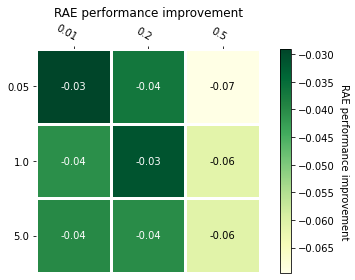

<Figure size 432x288 with 0 Axes>

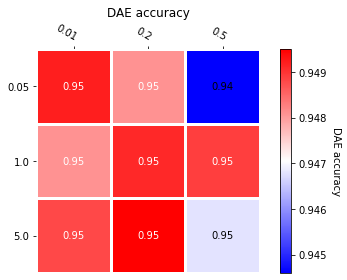

<Figure size 432x288 with 0 Axes>

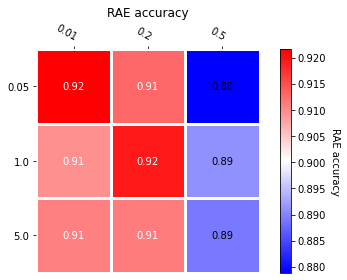

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
plt.title('RAE performance improvement')
im, cbar = heatmap(l1_performance, lambda_l1_list, corr_l1_list, ax=ax,
                   cmap="YlGn", cbarlabel="RAE performance improvement")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()
plt.savefig(os.path.join(curr_dir, 'l1_experiment', 'performance.png'))

fig, ax = plt.subplots()
plt.title('DAE accuracy')
im, cbar = heatmap(l1_DAE_results, lambda_l1_list, corr_l1_list, ax=ax,
                   cmap="bwr", cbarlabel="DAE accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()
plt.savefig(os.path.join(curr_dir, 'l1_experiment', 'DAE_acc.png'))

fig, ax = plt.subplots()
plt.title('RAE accuracy')
im, cbar = heatmap(l1_RAE_results, lambda_l1_list, corr_l1_list, ax=ax,
                   cmap="bwr", cbarlabel="RAE accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()
plt.savefig(os.path.join(curr_dir, 'l1_experiment', 'RAE_acc.png'))

## L21 Experiments

In [55]:
RAEl21Dense = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=x_train_anomaly.shape[1], dense_units=[200, 10], lr=0.005)

In [56]:
LD_l21_MNIST, S_l21_MNIST = RAEl21Dense.train_and_fit(X=x_train_anomaly, train_iter=20, AE_train_iter=50, batch_size=128, eps=1e-8, lam=15., verbose=2)

RAE training iteration: 1
Epoch 1/50
46/46 - 0s - loss: 0.0690 - mse: 0.0690 - 423ms/epoch - 9ms/step
Epoch 2/50
46/46 - 0s - loss: 0.0430 - mse: 0.0430 - 148ms/epoch - 3ms/step
Epoch 3/50
46/46 - 0s - loss: 0.0325 - mse: 0.0325 - 136ms/epoch - 3ms/step
Epoch 4/50
46/46 - 0s - loss: 0.0293 - mse: 0.0293 - 119ms/epoch - 3ms/step
Epoch 5/50
46/46 - 0s - loss: 0.0275 - mse: 0.0275 - 120ms/epoch - 3ms/step
Epoch 6/50
46/46 - 0s - loss: 0.0262 - mse: 0.0262 - 115ms/epoch - 3ms/step
Epoch 7/50
46/46 - 0s - loss: 0.0251 - mse: 0.0251 - 120ms/epoch - 3ms/step
Epoch 8/50
46/46 - 0s - loss: 0.0241 - mse: 0.0241 - 121ms/epoch - 3ms/step
Epoch 9/50
46/46 - 0s - loss: 0.0232 - mse: 0.0232 - 122ms/epoch - 3ms/step
Epoch 10/50
46/46 - 0s - loss: 0.0227 - mse: 0.0227 - 112ms/epoch - 2ms/step
Epoch 11/50
46/46 - 0s - loss: 0.0221 - mse: 0.0221 - 111ms/epoch - 2ms/step
Epoch 12/50
46/46 - 0s - loss: 0.0215 - mse: 0.0215 - 108ms/epoch - 2ms/step
Epoch 13/50
46/46 - 0s - loss: 0.0213 - mse: 0.0213 - 118ms

In [57]:
inputsize = (28,28)
Image.fromarray(tile_raster_images(X=S_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21S_MNIST.png")
Image.fromarray(tile_raster_images(X=RAEl21Dense.get_reconstruction(x_train_anomaly).numpy(), img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21R_MNIST.png")
Image.fromarray(tile_raster_images(X=LD_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21L_MNIST.png")

In [58]:
print(S_l21_MNIST)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [59]:
#detected_anomalies = (np.sum((abs(S)>0.).astype(int), axis=1)>0.).astype(int)
detected_anomalies_MNIST = (np.linalg.norm(S_l21_MNIST, axis=1) > 0.).astype(int)
print(f'Detected_anomalies: {np.sum(detected_anomalies_MNIST)}')

true_anomalies_MNIST = np.zeros(x_train_digit.shape[0]).astype(int)
true_anomalies_MNIST[anomalies] = 1
np.sort(true_anomalies_MNIST)
accuracy_MNIST = accuracy_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
precision_MNIST = precision_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
recall_MNIST = recall_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
f1_MNIST = f1_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)

print(f'Accuracy: {accuracy_MNIST}, precision: {precision_MNIST}, recall: {recall_MNIST}, F1 score: {f1_MNIST}')



Detected_anomalies: 0
Accuracy: 0.9512153372132831, precision: 0.0, recall: 0.0, F1 score: 0.0


c:\Users\aless\MLgeneric\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
df = pd.read_csv(os.path.join('data', 'realKnownCause', 'machine_temperature_system_failure.csv'), delimiter=',', decimal='.')
df.drop_duplicates(subset='timestamp', keep='first', inplace=True)
ts_timestamps = df.iloc[:,0].values[33:-186]
ts_values = np.array(df.iloc[:,1].values[33:-186])

#ts_values_daily = ts_values.copy().reshape((int(ts_values.shape[0]/(12*24)), 12*24, 1))

timesteps = 144
ts_data = subsequences(ts_values, timesteps)

scaler = MinMaxScaler()
ts_data_scaled = scaler.fit_transform(X=ts_data)

ts_train_dense = ts_data_scaled.copy()
np.random.shuffle(ts_train_dense)
ts_train_LSTM = ts_data_scaled.reshape((ts_data_scaled.shape[0], timesteps, 1))
np.random.shuffle(ts_train_LSTM)

In [84]:
RAEl21Dense_ts = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=ts_train_dense.shape[1], dense_units=[60, 20], lr=0.005)

In [88]:
LD_l21_dense, S_l21_dense = RAEl21Dense_ts.train_and_fit(X=ts_train_dense, train_iter=20, AE_train_iter=50, batch_size=256, eps=1e-8, lam=0.5)

RAE training iteration: 1
Epoch 1/50
88/88 [==============================] - 0s 4ms/step - loss: 2.6061e-04 - mse: 2.6061e-04
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6161e-04 - mse: 2.6161e-04
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6002e-04 - mse: 2.6002e-04
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6206e-04 - mse: 2.6206e-04
Epoch 5/50
88/88 [==============================] - 0s 4ms/step - loss: 2.6458e-04 - mse: 2.6458e-04
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5582e-04 - mse: 2.5582e-04
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5901e-04 - mse: 2.5901e-04
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6261e-04 - mse: 2.6261e-04
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5827e-04 - mse: 2.5827e-04
Epoch 10/50
88/88 [==============================] - 0s 3ms/step 

[0 0 0 ... 0 0 0]
Detected anomalies: 428


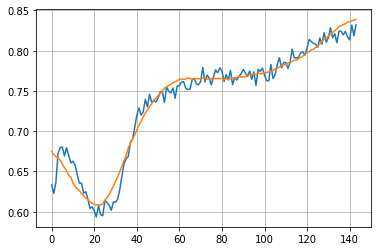

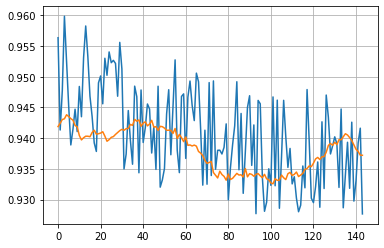

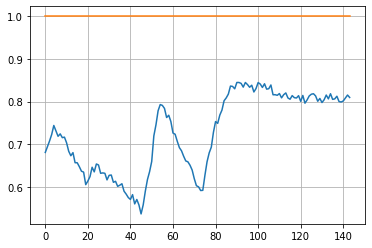

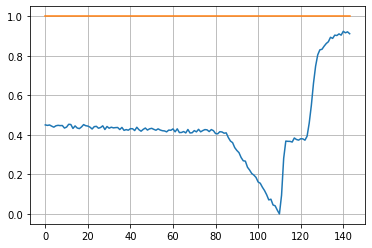

In [89]:
detected_anomalies_dense = (np.linalg.norm(S_l21_dense, axis=1) > 0.).astype(int)
print(detected_anomalies_dense)
print(f'Detected anomalies: {np.sum(detected_anomalies_dense)}')

#plot_ts_recon(ts_train_dense[0], RAEl21Dense_ts.get_reconstruction(ts_train_dense[0].reshape((1,-1))).numpy().reshape((-1)))
plot_ts_recon(ts_train_dense[0], LD_l21_dense[0])
plot_ts_recon(ts_train_dense[1000], LD_l21_dense[1000])
anomalies = np.argwhere(detected_anomalies_dense)
np.random.shuffle(anomalies)
plot_ts_recon(ts_train_dense[anomalies[0][0]], LD_l21_dense[anomalies[0][0]])
plot_ts_recon(ts_train_dense[anomalies[1][0]], LD_l21_dense[anomalies[1][0]])


In [115]:
RAEl21LSTM = RobustAutoencoder(AE_type='LSTM', prox_type='l21', timesteps=timesteps, features=1, lr=3e-4, LSTM_dropout=0.0, LSTM_units=[32, 16])

In [116]:
LD_l21_LSTM, S_l21_LSTM = RAEl21LSTM.train_and_fit(X=ts_train_LSTM, AE_train_iter=25, train_iter=10, lam=2., batch_size=256, eps=1e-8)

RAE training iteration: 1
Epoch 1/25
88/88 [==============================] - 7s 35ms/step - loss: 0.0386 - mse: 0.0386
Epoch 2/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0134 - mse: 0.0134
Epoch 3/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0072 - mse: 0.0072
Epoch 4/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0057 - mse: 0.0057
Epoch 5/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0050 - mse: 0.0050
Epoch 6/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0044 - mse: 0.0044
Epoch 7/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0040 - mse: 0.0040
Epoch 8/25
88/88 [==============================] - 3s 31ms/step - loss: 0.0038 - mse: 0.0038
Epoch 9/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0037 - mse: 0.0037
Epoch 10/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0036 - mse: 0.0036
Epoch 11/25
88/88 [==============

[0 0 0 ... 0 0 0]
Detected anomalies: 320


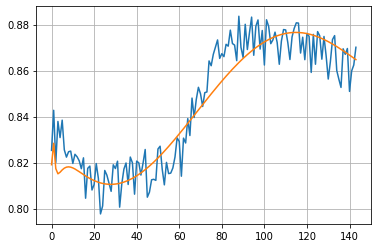

In [117]:
from pyexpat import features
from time import time


shrinked_shape = (ts_train_LSTM.shape[0], ts_train_LSTM.shape[1])

detected_anomalies_LSTM = (np.linalg.norm(S_l21_LSTM.reshape(shrinked_shape), axis=1) > 0.).astype(int)
print(detected_anomalies_LSTM)
print(f'Detected anomalies: {np.sum(detected_anomalies_LSTM)}')

shrinked_shape = (ts_train_LSTM.shape[0], ts_train_LSTM.shape[1])
plot_ts_recon(ts_train_LSTM[0].reshape(timesteps), RAEl21LSTM.get_reconstruction(ts_train_LSTM[0].reshape((1,timesteps,1))).numpy().reshape((timesteps)))

[0 0 0 ... 0 0 0]
Detected anomalies: 320
0


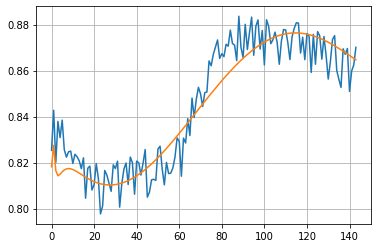

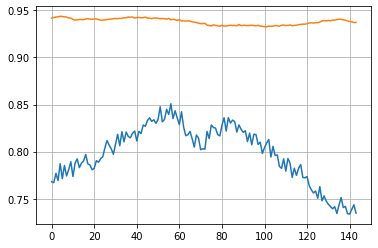

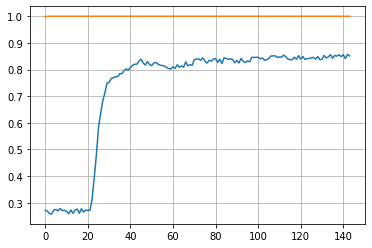

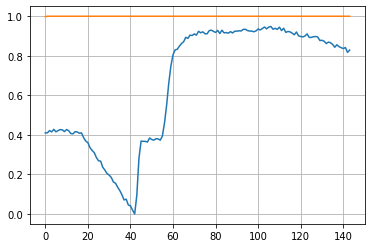

In [119]:
detected_anomalies_dense = (np.linalg.norm(S_l21_LSTM.reshape(shrinked_shape), axis=1) > 0.).astype(int)
print(detected_anomalies_dense)
print(f'Detected anomalies: {np.sum(detected_anomalies_dense)}')
print(detected_anomalies_LSTM[1000])
#plot_ts_recon(ts_train_dense[0], RAEl21Dense_ts.get_reconstruction(ts_train_dense[0].reshape((1,-1))).numpy().reshape((-1)))
plot_ts_recon(ts_train_LSTM[0], LD_l21_LSTM[0])
plot_ts_recon(ts_train_LSTM[1000], LD_l21_dense[1000])
anomalies = np.argwhere(detected_anomalies_LSTM)
np.random.shuffle(anomalies)
plot_ts_recon(ts_train_LSTM[anomalies[0][0]], LD_l21_LSTM[anomalies[0][0]])
plot_ts_recon(ts_train_LSTM[anomalies[2][0]], LD_l21_LSTM[anomalies[2][0]])